# Lab | Imbalanced data

We will be using the files_for_lab/customer_churn.csv dataset to build a churn predictor.

**Instructions**

1. Load the dataset and explore the variables.
2. We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.
3. Extract the target variable.
4. Extract the independent variables and scale them.
5. Build the logistic regression model.
6. Evaluate the model.
7. Even a simple model will give us more than 70% accuracy. Why?
8. Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply imblearn.over_sampling.SMOTE to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

**BONUS:** Try regular over and undersampling

https://github.com/NicolasVollmer/lab-imbalanced-data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
churn = pd.read_csv("files_for_lab/customer_churn.csv")
print(churn.shape)
churn.head(10)

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [4]:
churn.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

want to check value counts, but with these many columns, I programmed a quick loop to do it for me

In [5]:
churn.dtypes


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
for col in churn.columns:
    print(churn[col].value_counts(), '''
    ''')

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64 
    
Male      3555
Female    3488
Name: gender, dtype: int64 
    
0    5901
1    1142
Name: SeniorCitizen, dtype: int64 
    
No     3641
Yes    3402
Name: Partner, dtype: int64 
    
No     4933
Yes    2110
Name: Dependents, dtype: int64 
    
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64 
    
Yes    6361
No      682
Name: PhoneService, dtype: int64 
    
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64 
    
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64 
    
No                     3498
Yes                    2019
No internet service    1526
Name: Online

OneHot = gender, InternetService, Contract, PaymentMethod

Seem like a few columns have two categories for 'no', depending if they had booked a necessary service or not, will first try to delete these duplicate no answers and simply merge them into one.

Also, the yes/no columns should be coded as 0 for no or 1 for yes.

Additionally, I may want to bin tenure with it's 73 values into various duration bins from short-term, to very long-term - the same might be applicable to MonthlyCharges and TotalCharges let's see how my model turns out first.

### cleaning yes/no columns

In [17]:
nointservice = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
binary = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

In [8]:
churn['MultipleLines'] = np.where(churn['MultipleLines'].isin(['No phone service']), 'No', churn['MultipleLines'])

In [20]:
churn['MultipleLines'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [10]:
for col in nointservice:
    churn[col] = np.where(churn[col].isin(['No internet service']), 'No', churn[col])

In [18]:
churn['Churn'] = churn['Churn'].map({'Yes':1 ,'No':0})

In [19]:
churn['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [ ]:
for col in churn.columns:
    print(churn[col].value_counts(), '''
    ''')

In [ ]:
for col in binary:
    churn[col] = churn[col].map({'Yes':1 ,'No':0})

In [ ]:
for col in churn.columns:
    print(churn[col].value_counts(), '''
    ''')

In [21]:
churn.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

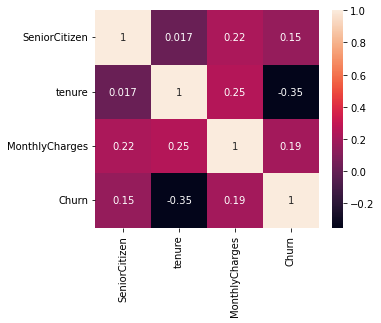

In [22]:
correlations_matrix = churn.corr()
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.heatmap(correlations_matrix, annot=True)
plt.show()

### Split and Scaling

In [23]:
X = churn.drop('Churn',axis = 1)
y = churn['Churn']

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # default fraction is .2

In [25]:
X_train_num = X_train.select_dtypes(include = np.number)
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [26]:
X_train_norm.columns = X_train_num.columns
X_train_norm

,SeniorCitizen,tenure,MonthlyCharges
0,0.0,0.333333,0.309263
1,1.0,0.750000,0.468127
2,0.0,0.041667,0.218127
3,0.0,0.847222,0.019920
4,0.0,0.166667,0.659363
...,...,...,...
5277,0.0,0.208333,0.848606
5278,0.0,0.138889,0.725598
5279,0.0,0.805556,0.024900
5280,1.0,0.013889,0.512948


In [ ]:
X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['type', 'operation', 'k_symbol', 'duration'],
                             drop_first=True)
X_train_cat.head()